# Vibration Absorber

[Download This Notebook](http://vibrationtoolbox.github.io/vibration_toolbox/_downloads/vibesystem_notebook-damper.ipynb)

In [1]:
import numpy as np
import vibration_toolbox as vtb
from ipywidgets import interact
import matplotlib.pyplot as plt
%matplotlib notebook

In this notebook a vibration absorber will be introduced in a system to decrease the vibration at the first mass.

![System](system_damp.png)

In [2]:
m0, m1, m2 = (1., 1, 1)
k0, k1, k2 = (1600., 1600, 1600)
alpha, beta = 1e-3, 1e-3

Now we use numpy to create our matrices:

In [3]:
M = np.array([[m0, 0, 0],
              [0, m1, 0],
              [0, 0, m2]])
K = np.array([[k0+k1, -k1,   0],
              [-k1, k1+k2, -k2],
              [0,     -k2,  k2]])
C = alpha*M + beta*K

In [4]:
sys = vtb.VibeSystem(M, C, K, name='3 dof system')

We can check the frequency response for specific input output pairs:

<IPython.core.display.Javascript object>


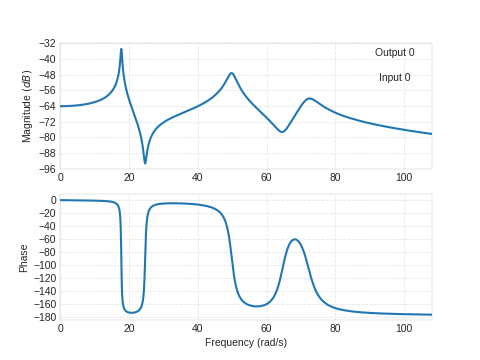

In [5]:
ax = sys.plot_freq_response(0, 0)

Now let's suppose that we have an excitation frequency at 17 $rad/s$ on $m_1$.

In [6]:
t = np.linspace(0, 25, 1000)
# force array with len(t) rows and len(inputs) columns
F1 = np.zeros((len(t), 3))
# in this case we apply the force only to the mass m1
F1[:, 1] = 1000*np.sin(17*t) 

<IPython.core.display.Javascript object>


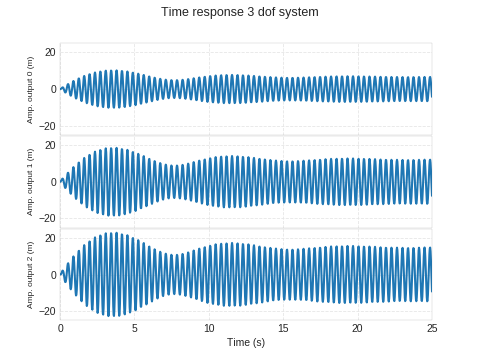

In [7]:
ax = sys.plot_time_response(F1, t)

We can use the plot_fft function available in the toolbox to see the FFT from the time response.

<IPython.core.display.Javascript object>


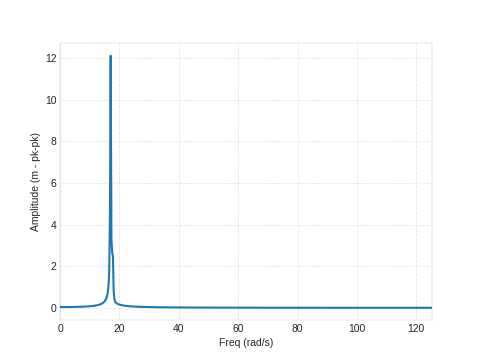

In [8]:
fig, ax = plt.subplots()
t, yout, xout = sys.time_response(F1, t)
vtb.plot_fft(t, time_response=yout[:, 0], ax=ax);

If we want to decrease the vibration at this mass we can add a vibration absorber.
The mass, stifness and damping of the absorber can be tuned with the sliders below:

In [9]:
@interact(m_damp=(1e-6, 1), k_damp=(100, 100000), c_damp=(1, 1000))
def damp_system(m_damp, k_damp, c_damp):
    # create padded matrices to add extra row/column
    Md = np.pad(M, (0, 1), mode='constant')
    Kd = np.pad(K, (0, 1), mode='constant')
    Cd = np.pad(C, (0, 1), mode='constant')
    F1d = np.pad(F1, [(0, 0), (0, 1)], mode='constant')

    # add parameters from the absorber
    Md[-1, -1] +=  m_damp

    Kd[-1, -1] += k_damp
    Kd[-1, -2] -= k_damp
    Kd[-2, -1] -= k_damp
    Kd[-2, -2] += k_damp

    Cd[-1, -1] += c_damp
    Cd[-1, -2] -= c_damp
    Cd[-2, -1] -= c_damp
    Cd[-2, -2] += c_damp

    # create new system 
    sys_damped = vtb.VibeSystem(Md, Cd, Kd, name='3 dof system with damper')
    
    # get response from original and new system
    _, yout0, xout0 = sys.time_response(F1, t)
    _, yout, xout = sys_damped.time_response(F1d, t)
    
    # plot fft for both systems
    fig, ax = plt.subplots()
    ax = vtb.plot_fft(t, time_response=yout0[:, 0], ax=ax, label='Original system')
    ax = vtb.plot_fft(t, time_response=yout[:, 0], ax=ax, label='System with absorber', alpha=0.8)
    ax.legend()
    plt.show()